# Predictive Price Analytics for Car Pricing

#### Authors:

* Bryzik Michał
* Gruca Kacper
* Kostecka Zuzanna
* Stolarska Karolina




### Introduction
In this project we have decided to look at different researches existing in the area of car price prediction and recreate the undertaken approaches to see how we could improve them and whether we would come to the same conclusion, even while using different datasets. We based our research on:

- [Nyenish09: Prediction of Automobile price in R](https://rpubs.com/nyenish09/857875?fbclid=IwZXh0bgNhZW0CMTAAAR0xa4yHuh6rJ4q9mXB7C6F00_IWrWAg56DjRR_hEUxXCKjYjYH6uMYs9bY_aem_AdwV_YdZ7TRgWutk8yl2TEgrrTSeC5wXkclRwegVv4qp9WpB_tF_Bz9USAzGaIfi1cTHo9TWXPfcH4GoJ_J1fHzG)
- [PyMati: Car Price Prediction in Python](https://github.com/PyMati/Car-Price-Prediction-Regression/blob/main/Car-Price-Regression-Model-Notebook.ipynb)
- [Suhasmadalli: Car-Prices-Prediction in Python](https://github.com/suhasmaddali/Car-Prices-Prediction/tree/main)

### Data

We obtained the data from the most popular portal with car sales advertisements [otomoto.pl](https://www.otomoto.pl/). In order to do so we used the solution found on hte github. We adapted the program to our needs and scraped all advertisements from this page.

We highly encourage you to visit this profile and familiarize yourself with the scraper.

- [jedrzejd: Otomoto-Scraper](https://github.com/jedrzejd/Otomoto-Scraper?fbclid=IwZXh0bgNhZW0CMTAAAR0nxWKNJAEkiVbs2yDCjFwgRcsDyIA4xo6122NSBbvPIEACLOD9CTvkZS4_aem_AaqvvGMkCvQc49QJ1YPswpS9Jaoh4fnefBhTaw76J-2r4MVweqxtrrG_2mQlf50LWY8PbAdRqGG4lh-CHNXMC1cV)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os 
import logging
import datetime
import sys

from matplotlib.cm import viridis
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR
from xgboost import XGBRegressor
from functions.modelling import *


### Cleaning

**Description**

In order to ensure reproducibility, all data cleaning steps have been packed into a `data_cleaning.py` file where we can easily parse the data to.

Before that, a few "temporary" cleaning notebooks were created to find insights in data and obtain general information for cleaning purposes.

Below are the steps of cleaning data.

**1. Drop Columns**

In the first step, we deleted all unnecessary columns and left the most important ones. We mapped them to English names.

Columns to keep:

* 'Marka pojazdu': 'brand'
* 'Model pojazdu': 'model'
* 'Rok produkcji': 'year_production'    
* 'Przebieg': 'mileage'
* 'Pojemność skokowa': 'engine_capacity'
* 'Rodzaj paliwa': 'fuel_type'
* 'Moc': 'power'
* 'Skrzynia biegów': 'gearbox'
* 'Napęd': 'drive_type'
* 'Typ nadwozia': 'body_type'
* 'Liczba drzwi': 'doors'
* 'Kolor': 'color'
* 'Metalik': 'metallic'
* 'Kraj pochodzenia': 'country_origin'
* 'Pierwszy właściciel': 'first_owner'
* 'Bezwypadkowy': 'accident_free'
* 'Stan': 'condition'
* 'Cena': 'price'
* 'Waluta': 'currency'

**2. Drop Rows with Missing Values**

Exclude rows with missing values except for the column `accident_free` - this column has just one unique value "Tak". We changed it to 1 and we filled all NAs with 0.

**3. Filter Brands**

Retain rows where `brand` is one of the predefined brands, defined below. We chose these brands that had >= 1000 observations. In order to make this process reproducible, we defined these brands so that scraping results do not affect the model.

* 'BMW'
* 'Audi'
* 'Ford'
* 'Skoda'
* 'Renault'
* 'Peugeot'
* 'Volvo'
* 'Kia'
* 'Hyundai'
* 'Citroën'
* 'Nissan'
* 'Mazda'
* 'Seat'
* 'Fiat'
* 'Honda'
* 'Volkswagen'
* 'Mercedes-Benz'
* 'Suzuki'
* 'Jeep'
* 'Opel'
* 'Dacia'
* 'MINI'
* 'Mitsubishi'
* 'Toyota'
* 'Land Rover'
* 'Lexus'
* 'Chevrolet'
* 'Alfa Romeo'
* 'Dodge'
* 'Jaguar'
* 'Subaru'

**4. Filter by Production Year**

* Convert `year_production` to integer.
* Retain rows where `year_production` is greater than 1999.

**5. Clean Mileage**

* Remove ' km' and spaces from `mileage`, convert to integer.
* Exclude rows where `mileage` is greater than 800,000.

**6. Clean Engine Capacity**

* Remove ' cm3' and spaces from `engine_capacity`, convert to integer.

**7. Filter Fuel Types**

* Exclude rows where `fuel_type` is 'Benzyna+CNG' or 'Wodór'.

**8. Clean Power**

* Remove ' KM' and spaces from `power`, convert to integer.
* Exclude rows where `power` is not between 4 and 1500.

**9. Map Gearbox to Binary**

* Map `gearbox` values to binary (Manualna → 0, Automatyczna → 1).
* Rename `gearbox` to `automatic_gearbox`.

**10. Map Drive Type**

* Map `drive_type` values to English equivalents and consolidate some categories.

**11. Filter and Map Body Type**

* Map `body_type` values to English equivalents.
* Exclude rows where `body_type` is not in the predefined mapping dictionary.

**12. Process Doors (Optional)**

* Convert `doors` to integer and exclude rows where `doors` is greater than 5.
* Map `doors` to binary values - map 2 and 3 doors to "0" and 4, 5 doors to "1" and rename to `doors_5`.

**13. Map Colors**

* Translate `color` values to English equivalents using a predefined dictionary.

**14. Clean Accident Free**

* Replace 'Tak' with 1 in `accident_free`, fill missing values with 0, and convert to integer.

**15. Map Condition**

* Map `condition` values to English equivalents using a predefined dictionary.

**16. Process Price**

* Convert `price` to numeric, drop rows with missing values after conversion.
* Exclude rows where `currency` is not PLN or EUR.
* Convert prices in EUR to PLN using a predefined exchange rate and update currency to PLN.
* Convert `price` to integer.

**17. One-Hot Encoding (Optional)**

* Perform one-hot encoding on selected categorical columns.
* Replace spaces in column names with underscores.
* Drop the `currency` column after encoding.

By following these steps, we ensure a consistent and clean dataset ready for further analysis and modeling. Each step addresses specific aspects of the raw data, making sure that irrelevant information is removed, and the remaining data is in a format suitable for analysis.

Below we use function to clean the dataset. We create 2 datasets, one for Exploratory Data Analysis purposes (with categorical data) and one for modelling data (with one hot encoded variables).


In [2]:
df = pd.read_csv('data/alternative_cleaning/alternative_cleaning.csv.gz', compression='gzip')
df_charts = pd.read_csv('data/alternative_EDA_cleaning.csv.gz', compression='gzip')

In [24]:
df_charts.head(5)

,brand,year_production,mileage,engine_capacity,fuel_type,power,automatic_gearbox,drive_type,body_type,doors,color,accident_free,condition,price,currency
0,Alfa Romeo,2012,104965,1368,Benzyna,105,0,Front_wheel_drive,Small_cars,3.0,Beige,1,Used_cars,17000,PLN
1,Alfa Romeo,2011,230500,1956,Diesel,136,0,Front_wheel_drive,Combi,4.0,Red,1,Used_cars,35000,PLN
2,Alfa Romeo,2010,182000,1742,Benzyna,235,0,Front_wheel_drive,Compact,5.0,Brown,0,Used_cars,34900,PLN
3,Alfa Romeo,2007,263773,2387,Diesel,200,0,Front_wheel_drive,Combi,4.0,Brown,1,Used_cars,18000,PLN
4,Alfa Romeo,2009,292000,1910,Diesel,150,0,Front_wheel_drive,Compact,4.0,Black,1,Used_cars,11500,PLN


As for our analysis we would like to focus on 3 different factors:
- Similarity of the datasets, distributions and tendencies within the data
- Similarity between the features of the data
- Accuracy of the chosen models and the predictions

### Exploratory Data Analysis

#### Distribution of car companies cars'

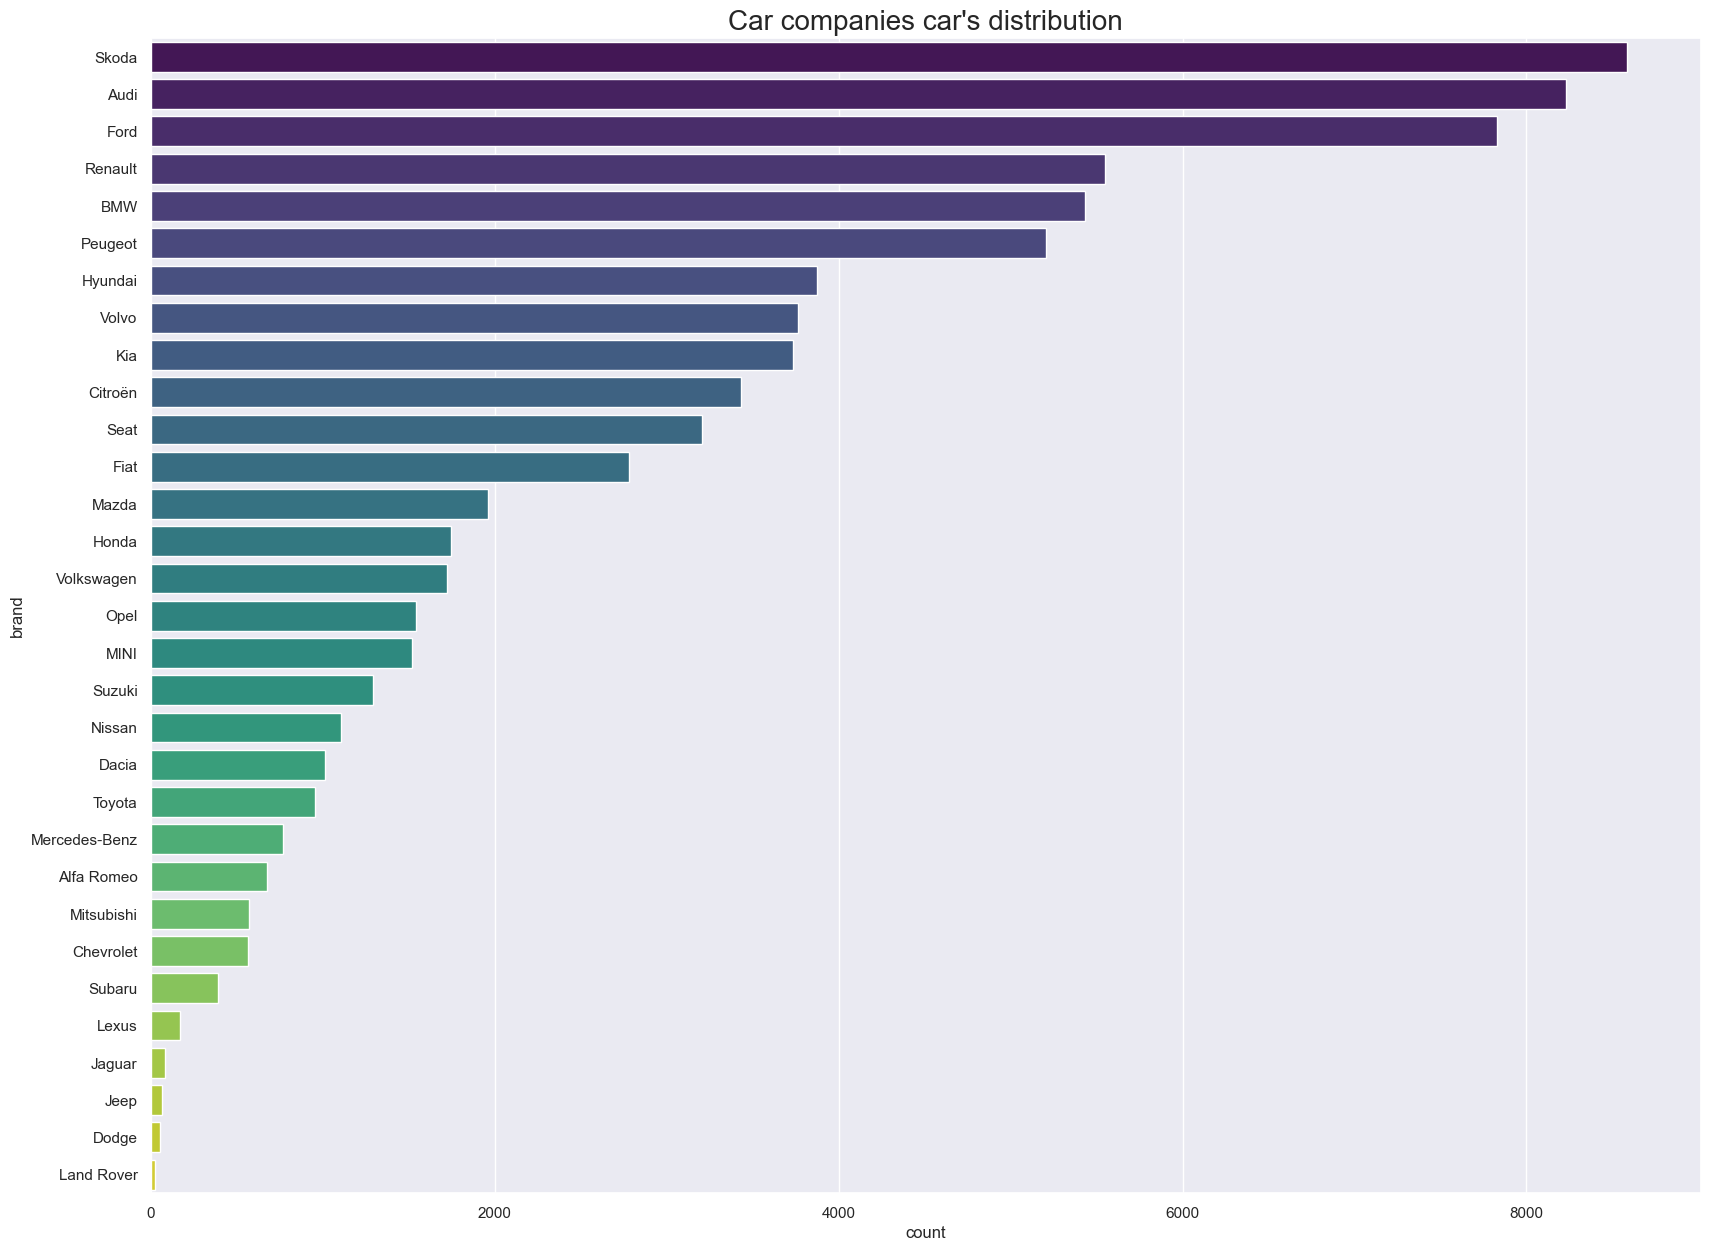

In [72]:
plt.figure(figsize=(20, 15))
sns.countplot(y = df_charts.brand, order = df_charts.brand.value_counts().index, palette = 'viridis')
plt.title("Car companies car's distribution", fontsize = 20)
plt.show()

#### Distribution of cars' production year

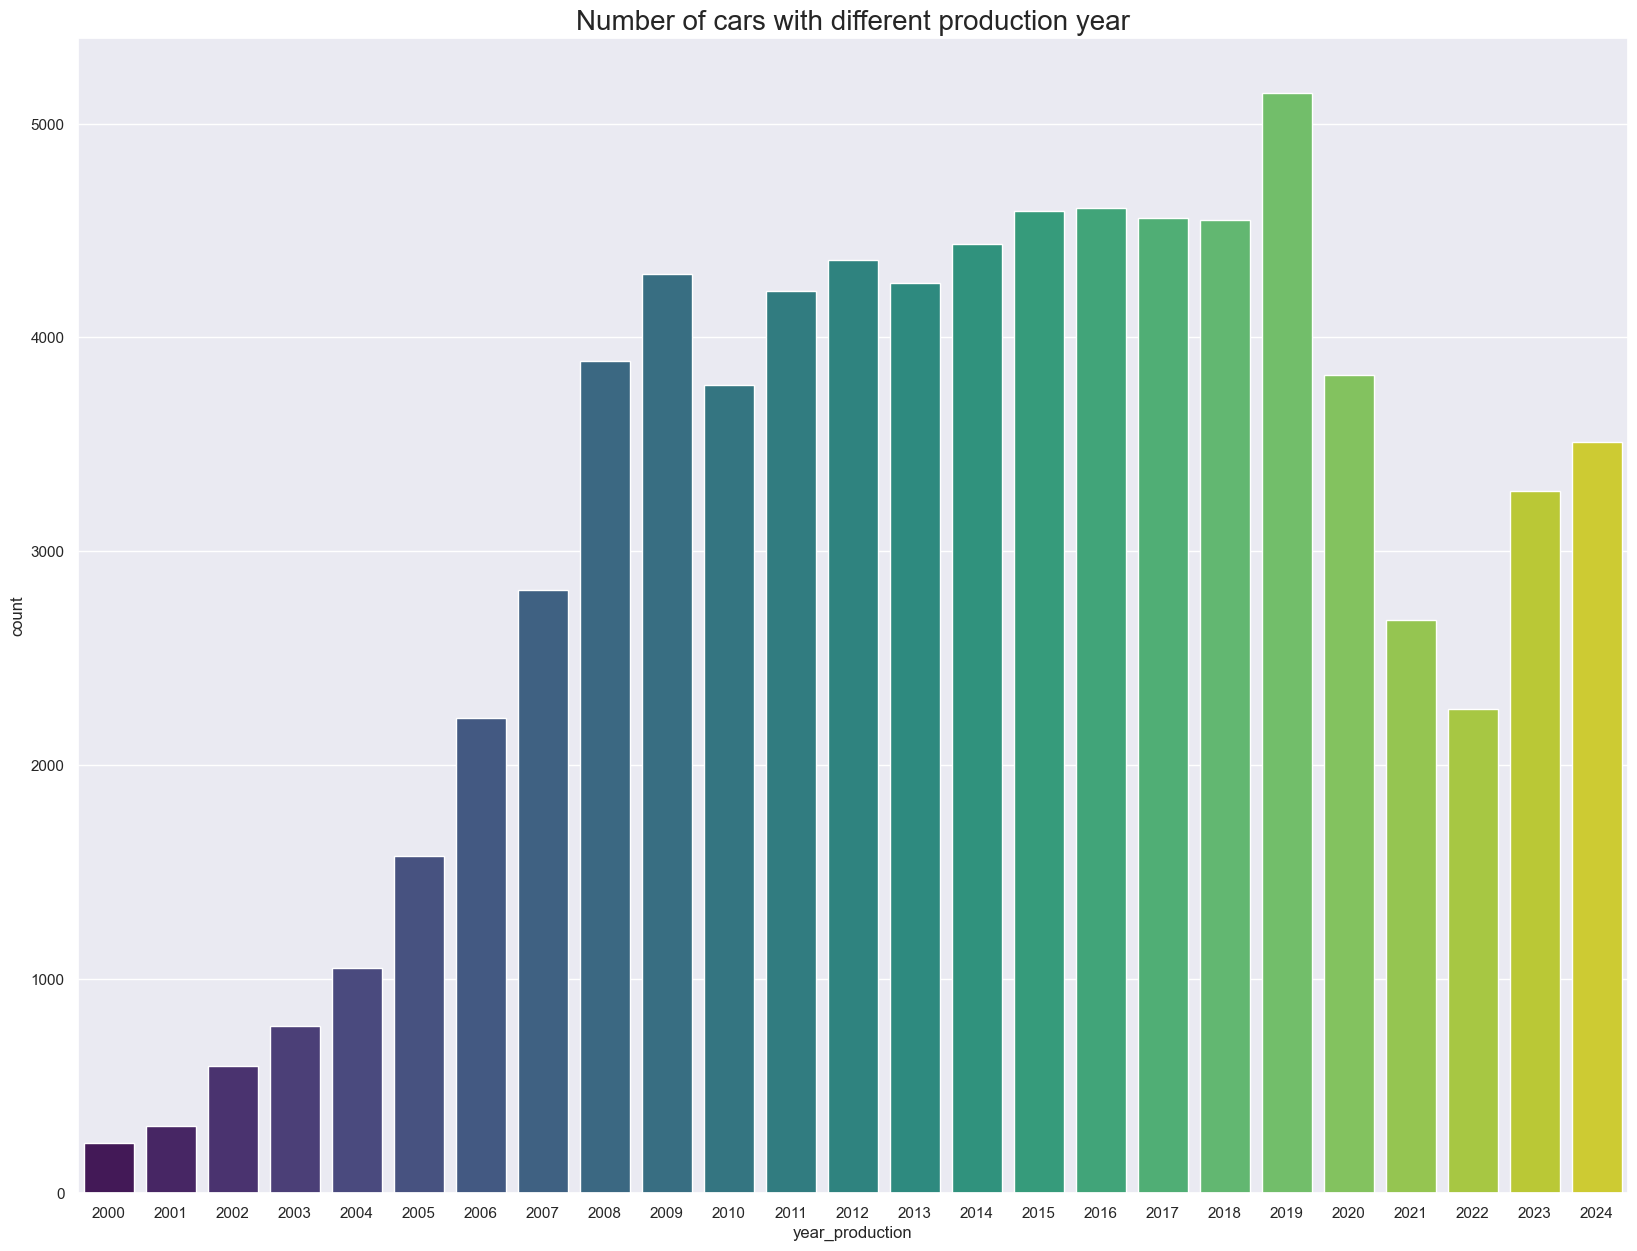

In [71]:
plt.figure(figsize = (20, 15))
sns.countplot(x = df_charts.year_production, palette = 'viridis')
plt.title("Number of cars with different production year", fontsize = 20)
plt.show()

#### Distribution of fuel type

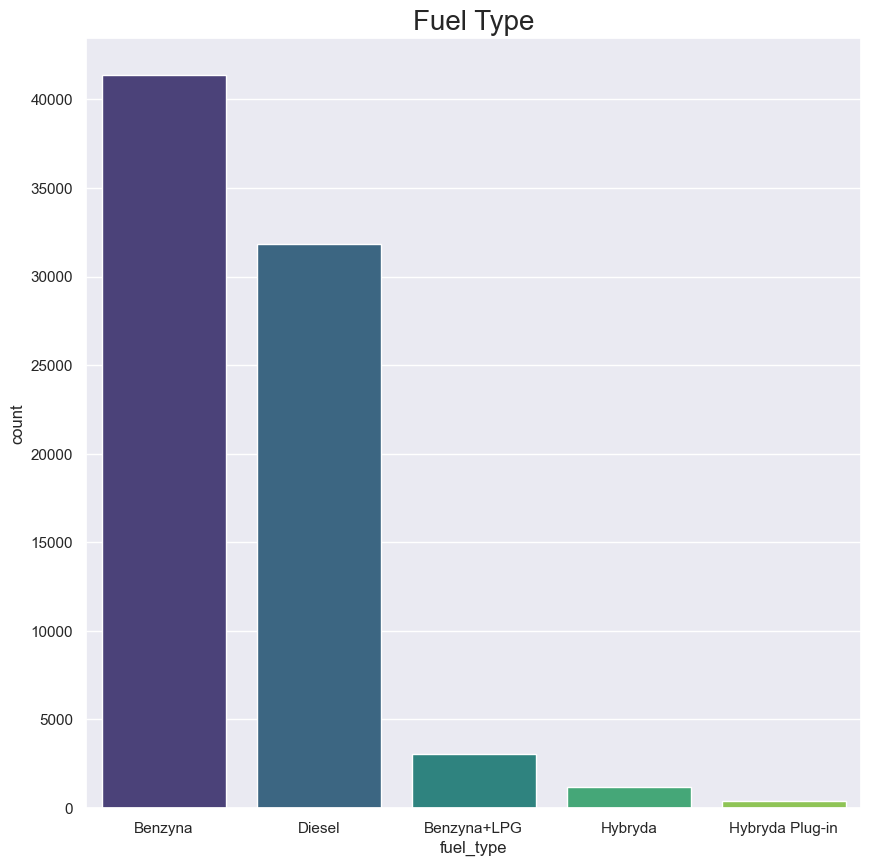

In [70]:
plt.figure(figsize = (10, 10))
sns.countplot(x=df_charts['fuel_type'], palette = 'viridis')
plt.title("Fuel Type", fontsize = 20)
plt.show()

#### Distribution of car type

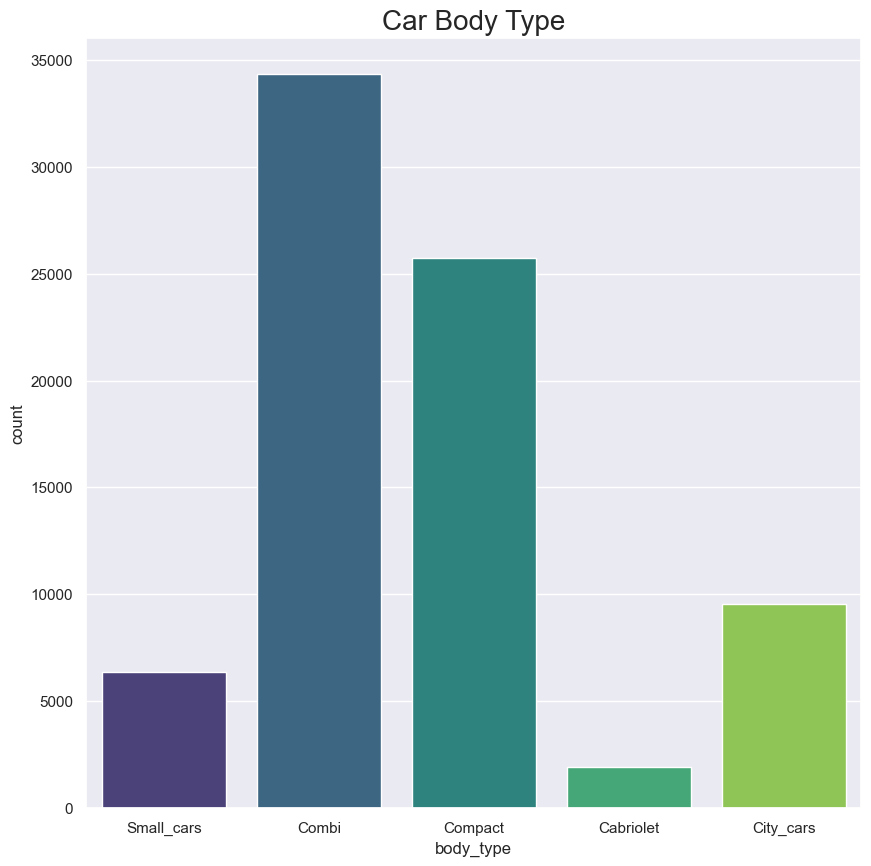

In [69]:
plt.figure(figsize = (10, 10))
sns.countplot(x=df_charts['body_type'], palette = 'viridis')
plt.title("Car Body Type", fontsize = 20)
plt.show()

#### Average Price of cars depending on their production year

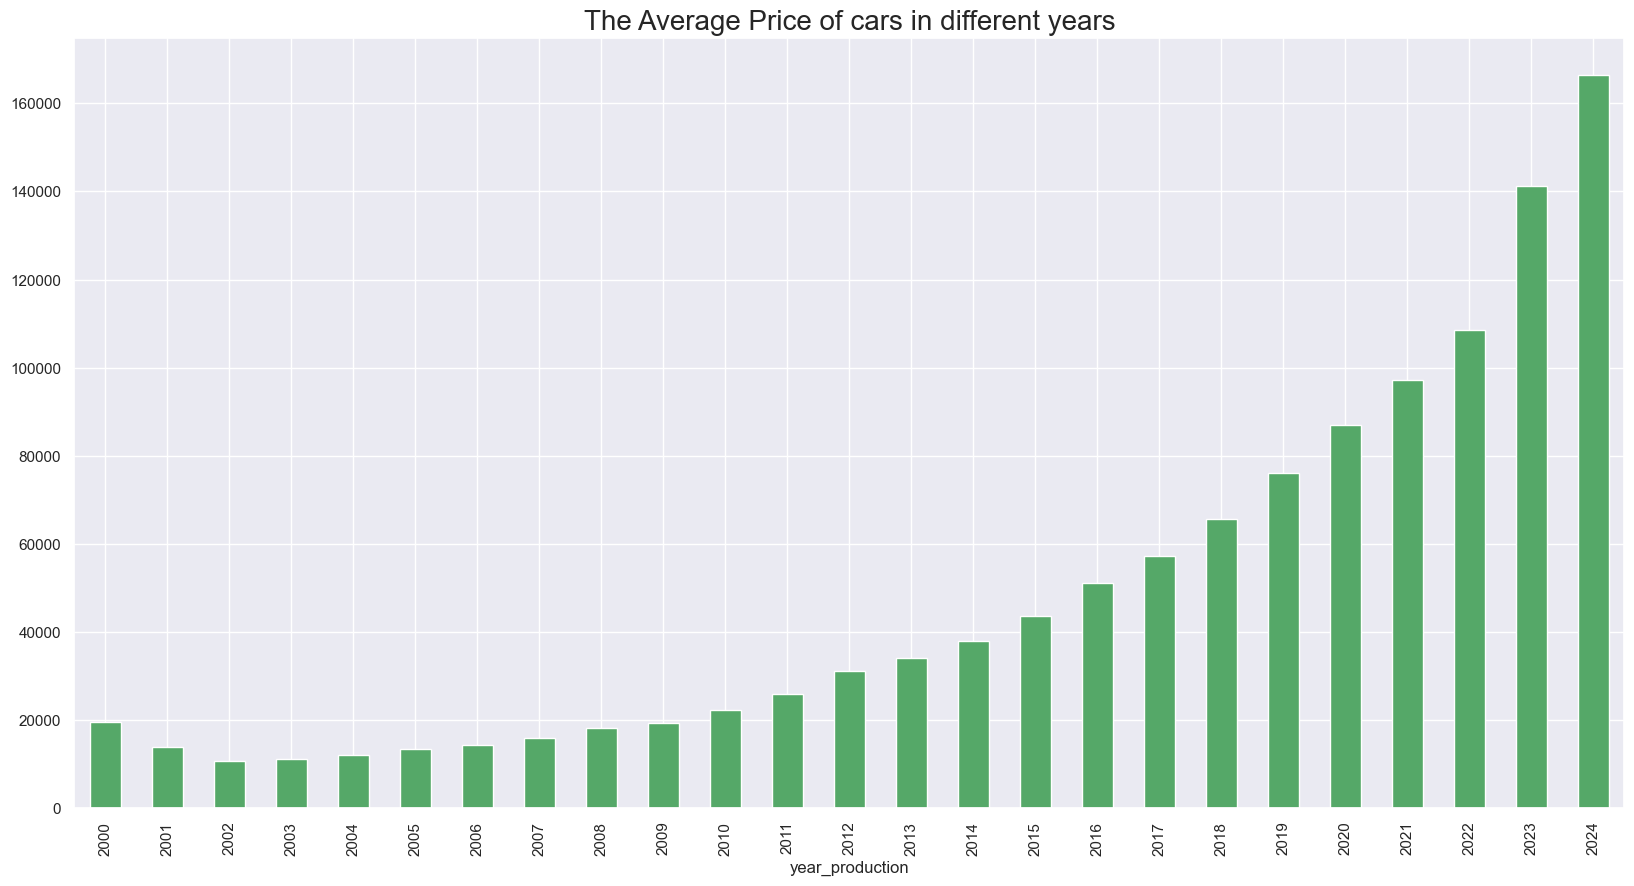

In [68]:
plt.figure(figsize = (20, 10))
df_charts.groupby('year_production')['price'].mean().plot(kind = 'bar', color = 'g')
plt.title("The Average Price of cars in different years", fontsize = 20)
plt.show()

#### Average price of cars by brands

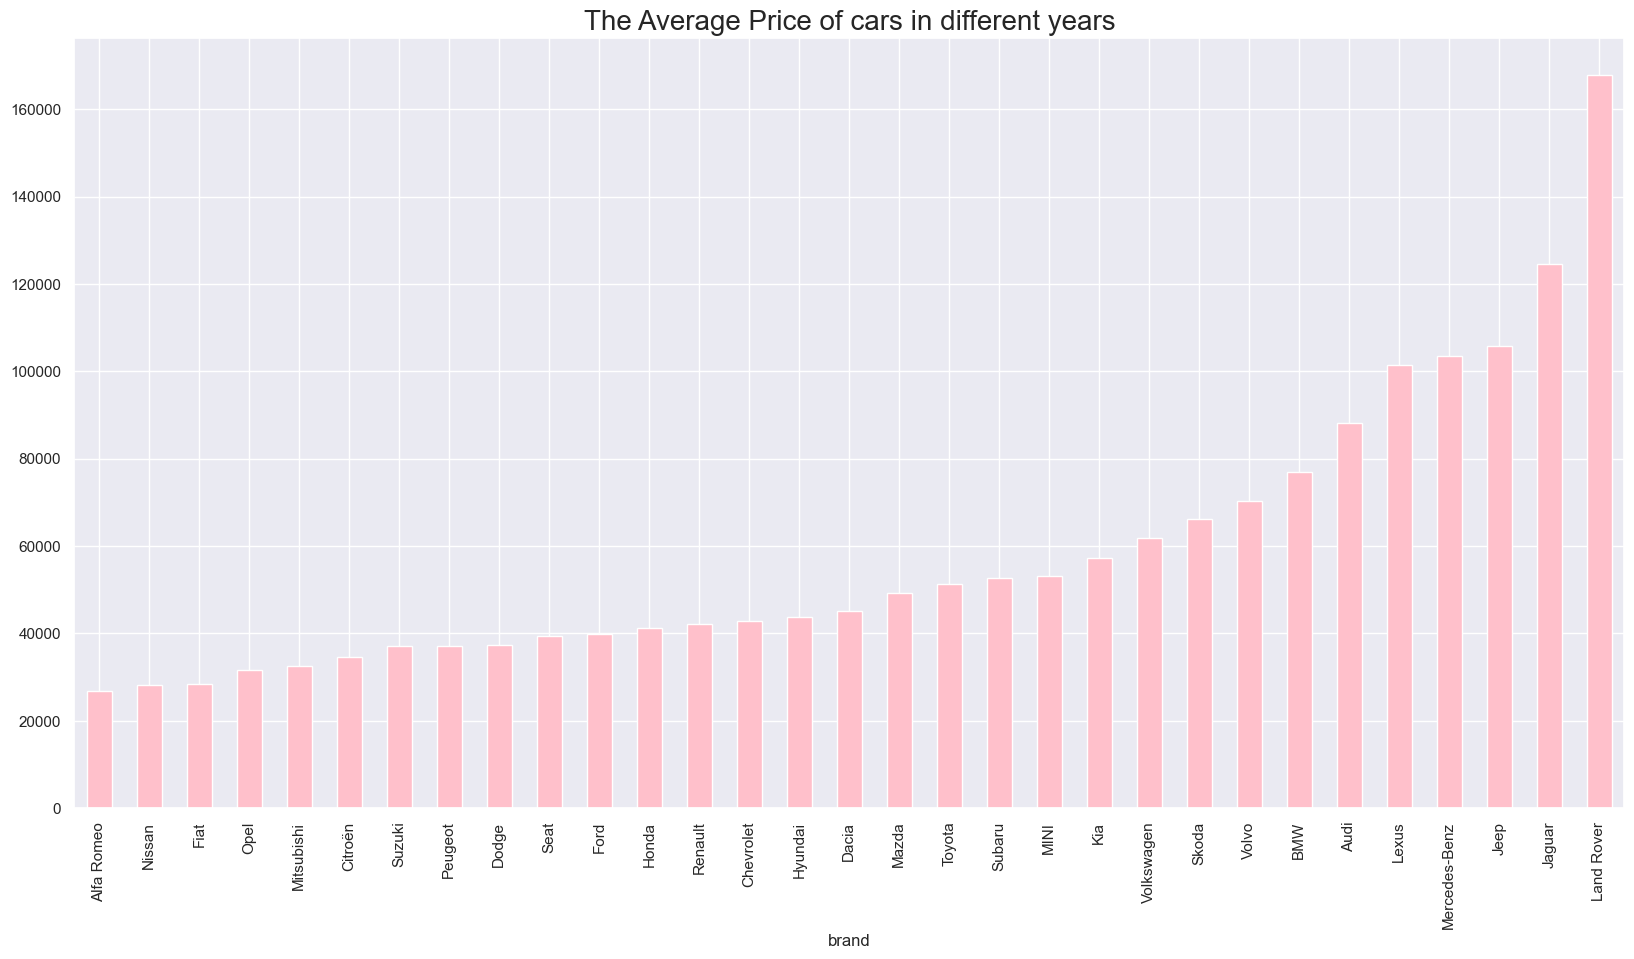

In [67]:
plt.figure(figsize=(20, 10))
df_charts.groupby('brand')['price'].mean().sort_values().plot(kind='bar', color='pink')
plt.title("The Average Price of cars in different years", fontsize=20)
plt.show()

### Modelling

In [3]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=12)

#### Feature Selection

In [53]:
selected_features_fi = select_features(df_train, 'price', method = 'feature_importance', n_features = 10)

In [4]:
selected_features_fi = ['year_production', 'power', 'engine_capacity', 'mileage', 'automatic_gearbox', 'drive_type_Front_wheel_drive', 'accident_free', 'brand_Audi', 'brand_BMW', 'brand_Mercedes-Benz']

In [74]:
rf = RandomForestRegressor()
rf.fit(df_train[selected_features_fi], df_train['price'])

importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': selected_features_fi, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [54]:
print('Selected features using Feature Importance:', selected_features_fi)

Selected features using Feature Importance: ['year_production', 'power', 'engine_capacity', 'mileage', 'automatic_gearbox', 'drive_type_Front_wheel_drive', 'accident_free', 'brand_Audi', 'brand_BMW', 'brand_Mercedes-Benz']


In [55]:
selected_features_rfe = select_features(df_train, 'price', method = 'RFE', n_features = 10)

In [5]:
selected_features_rfe = ['year_production', 'mileage', 'engine_capacity', 'power', 'automatic_gearbox', 'accident_free', 'brand_Audi', 'drive_type_Front_wheel_drive', 'body_type_Combi', 'color_Black']

In [56]:
print('Selected features using RFE:', selected_features_rfe)

Selected features using RFE: ['year_production', 'mileage', 'engine_capacity', 'power', 'automatic_gearbox', 'accident_free', 'brand_Audi', 'drive_type_Front_wheel_drive', 'body_type_Combi', 'color_Black']


#### Decision Tree

In [38]:
model_dt = DecisionTreeRegressor()
param_grid_dt = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [39]:
trained_model_dt, best_params_dt, avg_score_dt = train_model(
    df_train, 'price', selected_features_fi, model_dt, kf=3, 
    grid_search=True, param_grid=param_grid_dt
)

print("Best parameters for DecisionTreeRegressor:", best_params_dt)
print("Average MAE score for DecisionTreeRegressor:", avg_score_dt)


2024-06-06 15:12:41 INFO     Starting Grid Search for hyperparameter tuning..
2024-06-06 15:12:48 INFO     Finished Grid Search for hyperparameter tuning..
2024-06-06 15:12:48 INFO     Starting Model Fitting..
2024-06-06 15:12:48 INFO     Finishing Model Fitting..
2024-06-06 15:12:48 INFO     Evaluating the model..
2024-06-06 15:12:48 INFO     Finished Model Evaluation..
Best parameters for DecisionTreeRegressor: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Average MAE score for DecisionTreeRegressor: -357633628.3974548


In [40]:
mse_dt, y_pred_dt = predict_model(trained_model_dt, df_test, 'price', selected_features_fi, 
                            charts=False)


print("Best parameters:", best_params_dt)
print("Mean Squared Error:", mse_dt)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Mean Squared Error: 308986775.3722577


#### XGBoost

In [24]:
model_xgb = XGBRegressor()
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [26]:
trained_model_xgb, best_params_xgb, avg_score_xgb = train_model(
    df_train, 'price', selected_features_fi, model_xgb, kf=3, 
    grid_search=False, param_grid=param_grid_xgb
)

print("Best parameters for DecisionTreeRegressor:", best_params_xgb)
print("Average MAE score for DecisionTreeRegressor:", avg_score_xgb)


2024-06-06 14:58:27 INFO     Starting Grid Search for hyperparameter tuning..
2024-06-06 14:58:27 INFO     Finished Grid Search for hyperparameter tuning..
2024-06-06 14:58:27 INFO     Starting Model Fitting..
2024-06-06 14:58:28 INFO     Finishing Model Fitting..
2024-06-06 14:58:28 INFO     Evaluating the model..
2024-06-06 14:58:30 INFO     Finished Model Evaluation..
Best parameters for DecisionTreeRegressor: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, '

In [32]:
mse_xgb, y_pred_xgb = predict_model(trained_model_xgb, df_test, 'price', selected_features_fi, 
                            charts=False)

print("Best parameters:", best_params_dt)
print("Mean Squared Error:", mse_xgb)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Mean Squared Error: 212079838.66763586


#### SVR

In [33]:
model_svr = SVR()
param_grid_svr = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5, 1.0]
}

In [34]:
trained_model_svr, best_params_svr, avg_score_svr = train_model(
    df_train, 'price', selected_features_fi, model_svr, kf=3, 
    grid_search=False, param_grid=param_grid_svr
)

print("Best parameters for DecisionTreeRegressor:", best_params_svr)
print("Average MAE score for DecisionTreeRegressor:", avg_score_svr)


2024-06-06 15:01:47 INFO     Starting Grid Search for hyperparameter tuning..
2024-06-06 15:01:47 INFO     Finished Grid Search for hyperparameter tuning..
2024-06-06 15:01:47 INFO     Starting Model Fitting..
2024-06-06 15:03:35 INFO     Finishing Model Fitting..
2024-06-06 15:03:35 INFO     Evaluating the model..
2024-06-06 15:07:40 INFO     Finished Model Evaluation..
Best parameters for DecisionTreeRegressor: {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Average MAE score for DecisionTreeRegressor: -3422088775.730482


In [35]:
mse_svr, y_pred_svr = predict_model(trained_model_svr, df_test, 'price', selected_features_fi, 
                            charts=False)

print("Best parameters:", best_params_dt)
print("Mean Squared Error:", mse_svr)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Mean Squared Error: 3034531928.3182125


Combining the results of the models

In [41]:
models = ['SVR', 'Decision Tree', 'XGBoost']
mse_values = [mse_svr, mse_dt, mse_xgb]

### Final Results

#### Feature Importance

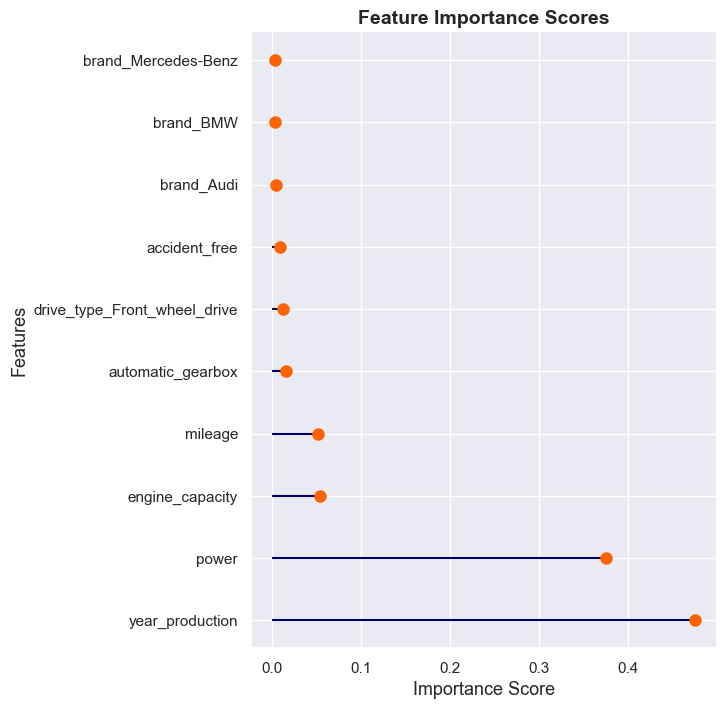

In [75]:
plt.figure(figsize=(6, 8))
plt.hlines(y=feature_importance_df['Feature'], xmin=0, xmax=feature_importance_df['Importance'], color='#000066')
plt.plot(feature_importance_df['Importance'], feature_importance_df['Feature'], 'o', markersize=8, color='#ff6200')
plt.title('Feature Importance Scores', fontsize=14, fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Importance Score', fontsize=13)
plt.ylabel('Features', fontsize=13)
plt.show()

#### Mean error along the models

In [19]:
models_other = ['Decision Tree', 'XGBoost','SVR']
mse_values_other = [135789622, 175275369, 2653742304]

models = ['Decision Tree', 'XGBoost', 'SVR']
mse_values = [308986775.3722577, 212079838.66763586,  3034531928.3182125]

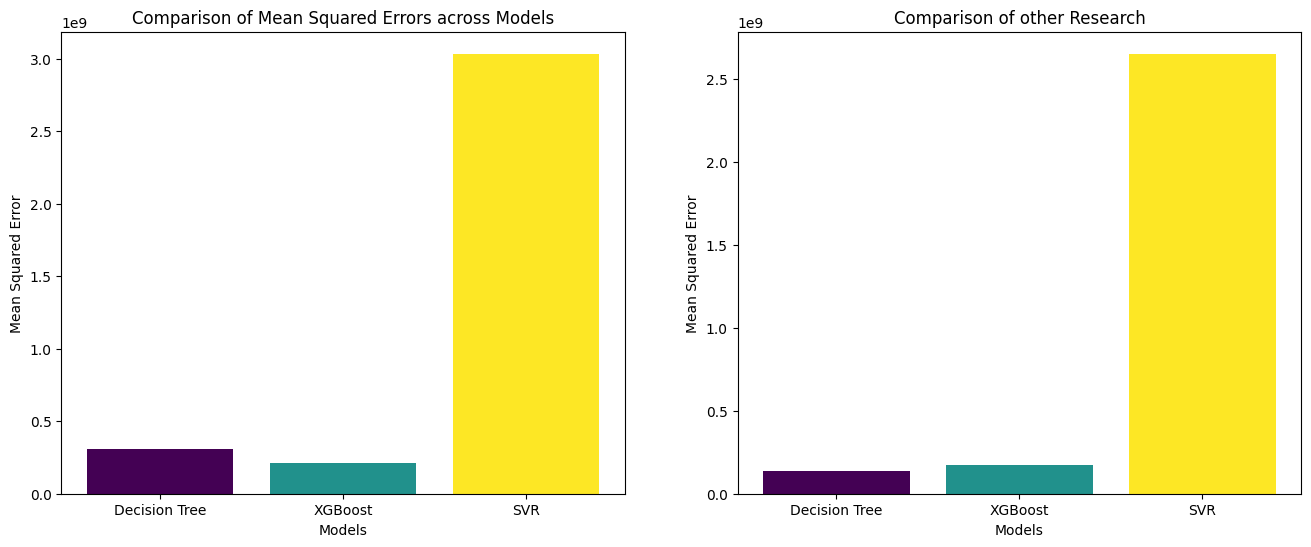

In [20]:
# Comparison of the Mean Squared Errors across models
colors = viridis(np.linspace(0, 1, len(mse_values)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(models, mse_values, color=colors)
ax1.set_xlabel("Models")
ax1.set_ylabel("Mean Squared Error")
ax1.set_title("Comparison of Mean Squared Errors across Models")

ax2.bar(models_other, mse_values_other, color=colors)
ax2.set_xlabel("Models")
ax2.set_ylabel("Mean Squared Error")
ax2.set_title("Comparison of other Research")
plt.show()

#### XGBoost Graph

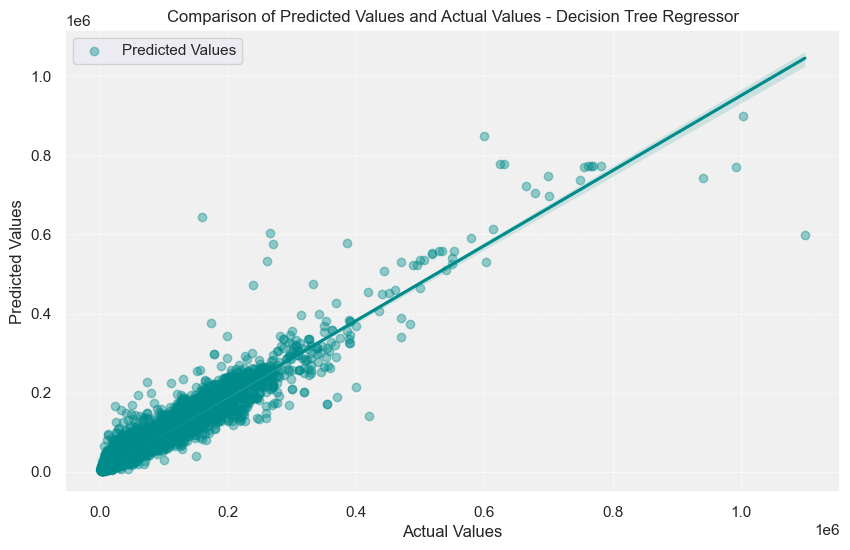

In [76]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

plt.scatter(df_test['price'], y_pred_xgb, color='darkcyan', alpha=0.4, label='Predicted Values')
sns.regplot(x=df_test['price'], y=y_pred_xgb, scatter=False, line_kws={'color': 'darkcyan'}, ci=95)

ax = plt.gca()
ax.set_facecolor('#f0f0f0')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Comparison of Predicted Values and Actual Values - Decision Tree Regressor")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#### SVR Graph

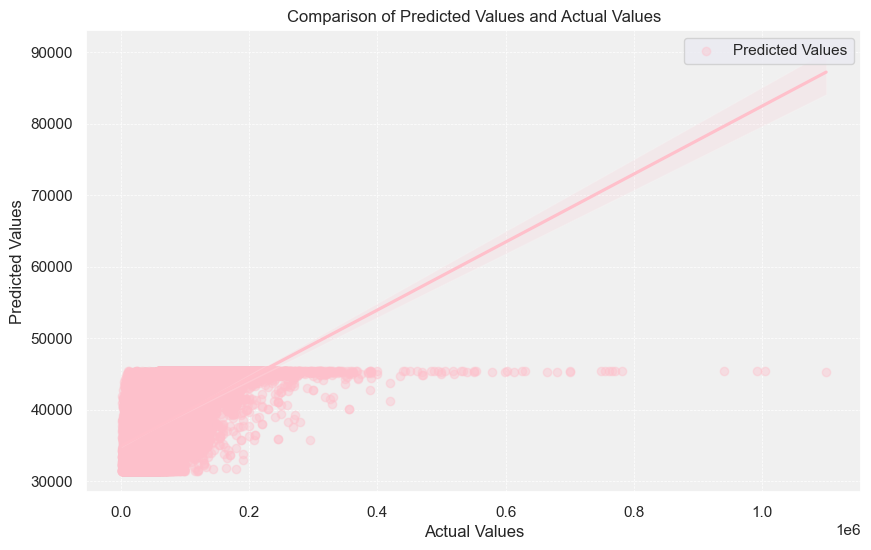

In [60]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

plt.scatter(df_test['price'], y_pred_svr, color='pink', alpha=0.4, label='Predicted Values')
sns.regplot(x=df_test['price'], y=y_pred_svr, scatter=False, line_kws={'color': 'pink'}, ci=95)

ax = plt.gca()
ax.set_facecolor('#f0f0f0')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Comparison of Predicted Values and Actual Values - SVR")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
#

#### Decision Tree Graph

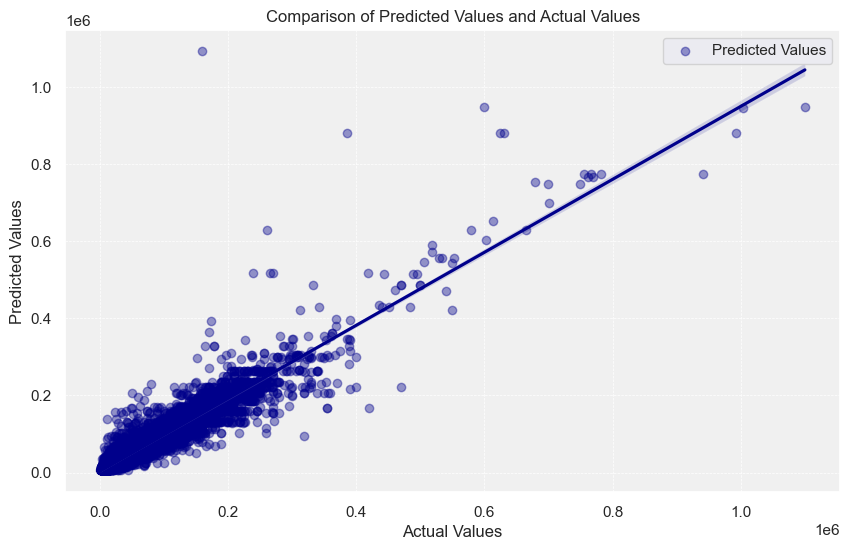

In [64]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

plt.scatter(df_test['price'], y_pred_dt, color='darkblue', alpha=0.4, label='Predicted Values')
sns.regplot(x=df_test['price'], y=y_pred_dt, scatter=False, line_kws={'color': 'darkblue'}, ci=95)

ax = plt.gca()
ax.set_facecolor('#f0f0f0')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Comparison of Predicted Values and Actual Values - Decision Tree")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()